In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
N=30 
sigma_obs=0.15
N_test=400
np.random.seed(0)
X = jnp.linspace(-1, 1, N)
Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

X_test = jnp.linspace(-1.3, 1.3, N_test)

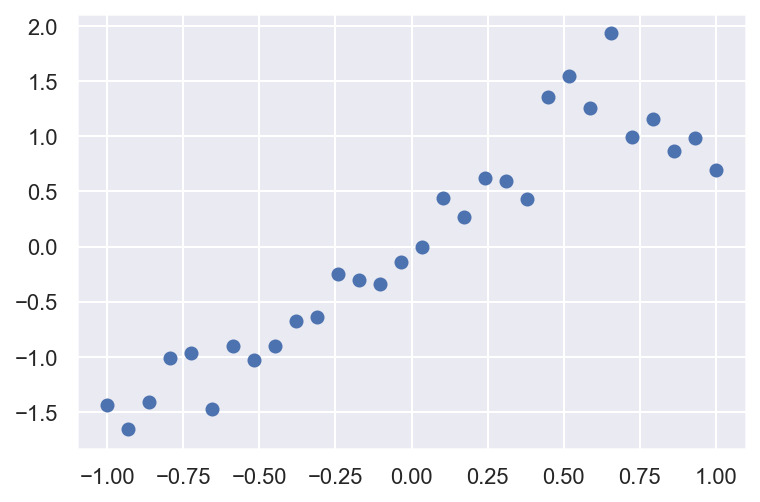

In [4]:
plt.scatter(X, Y);

In [5]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(rng_key, model, X, Y, init_strategy="median", num_warmup=1000, num_samples=1000, 
                  thinning=2, num_chains=1):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5})
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=num_chains, thinning=thinning,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [7]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(rng_key, model, X, Y, num_chains=1)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 304.34it/s, 7 steps of size 5.26e-01. acc. prob=0.92]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.65      0.24      0.60      0.33      1.02    412.07      1.00
   kernel_noise      0.07      0.02      0.07      0.04      0.10    421.63      1.00
     kernel_var      3.09      6.91      1.37      0.17      5.79    431.97      1.00

Number of divergences: 0

MCMC elapsed time: 6.891219854354858


In [8]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

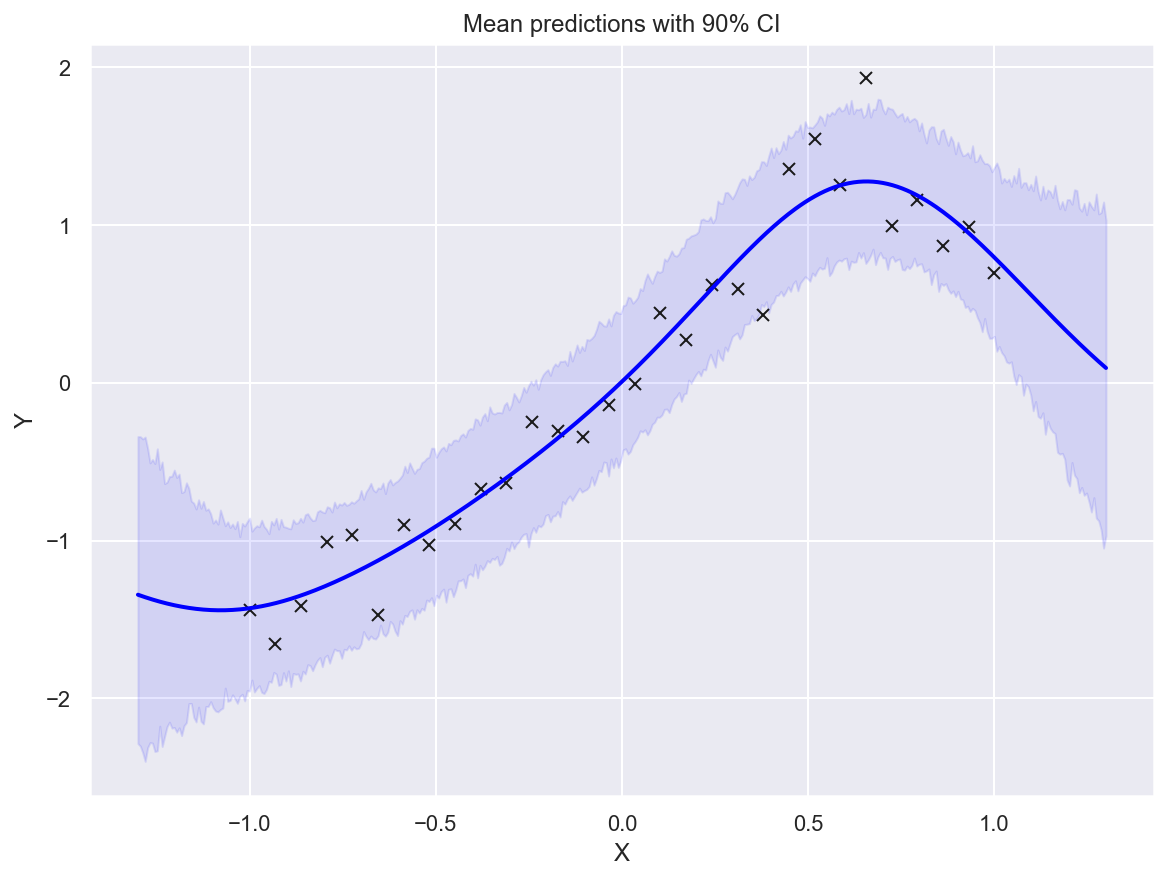

In [9]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, 'kx')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='blue', alpha=0.1)
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

# Cholesky

In [21]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)
    ck = jax.scipy.linalg.cholesky(k, lower=True)
    
    mu = jnp.zeros(X.shape[0])

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", 
                   dist.MultivariateNormal(loc=mu, scale_tril=ck),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(rng_key, model, X, Y, init_strategy="median", num_warmup=1000, num_samples=1000, 
                  thinning=2, num_chains=1):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5})
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=num_chains, thinning=thinning,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. 
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [22]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(rng_key, model, X, Y, num_chains=1)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 359.72it/s, 15 steps of size 4.66e-01. acc. prob=0.94]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.62      0.23      0.58      0.30      0.96    342.11      1.00
   kernel_noise      0.07      0.02      0.07      0.04      0.10    427.15      1.00
     kernel_var      2.88      7.93      1.22      0.22      4.87    344.28      1.00

Number of divergences: 0

MCMC elapsed time: 6.113749980926514


In [23]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

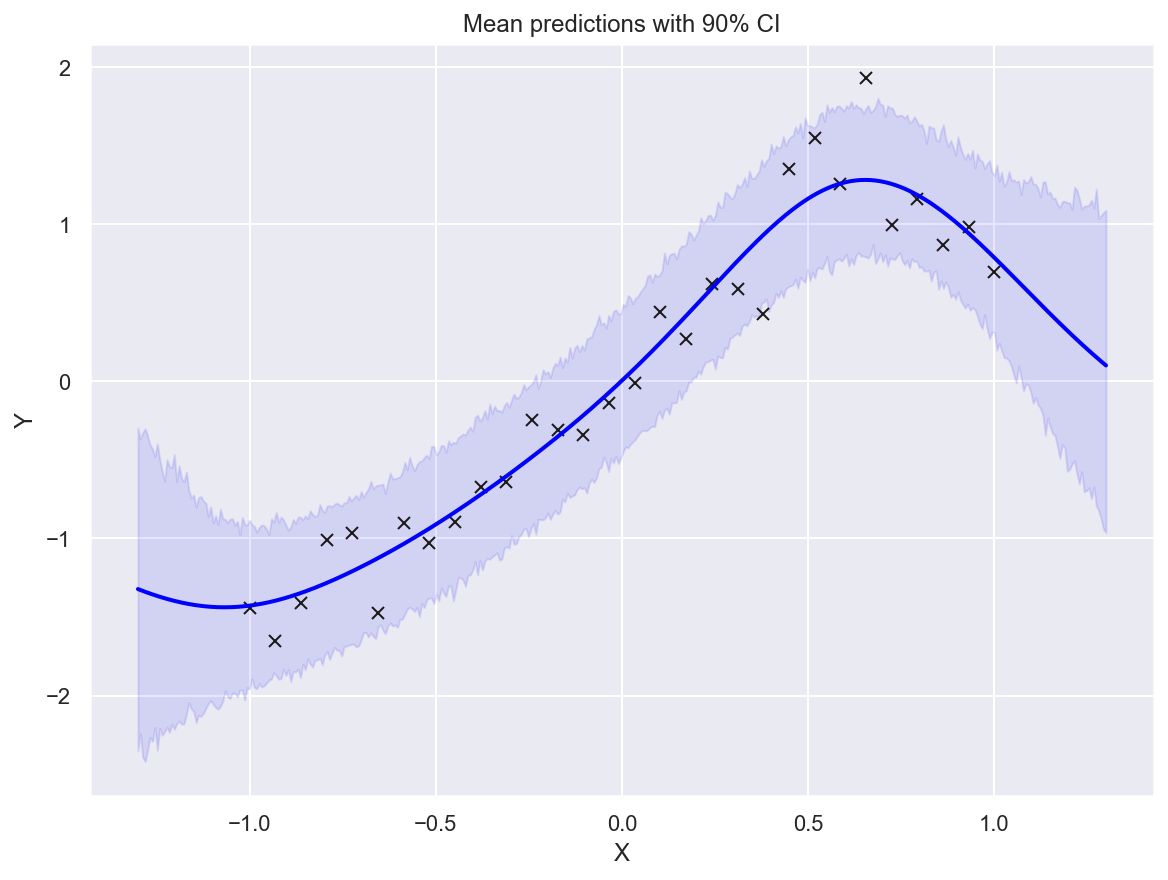

In [24]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, 'kx')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='blue', alpha=0.1)
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");